## Case study - assigning uncertainty

By Sofia Brisson
(credit to Elisa Heim for fishdist.py)

Here we apply all the routines performed for the synthetic fault model on a real-case, much more complex scenario. Before seeing this notebook, refer to the notebooks in the synthetic model folder which contain a more detailed description of the methodology.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import gempy as gp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from gempy.assets import topology as tp
from tqdm import tqdm_notebook
import seaborn as sns
import pandas as pd
from tqdm import tqdm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Calculate initial geomodel

In [2]:
geo_model1 = gp.create_model('Bregenz')
geo_mode1l = gp.init_data(geo_model1,
                         extent=[556000,574000,5234000,5275000,-6500,1300], #18 km by 41 km
                         resolution=[20,20,20],
                         path_o='or.csv',
                         path_i='surf.csv')

gp.map_stack_to_surfaces(geo_model1,
                        {'Fault_004' : ['Fault_004'],'Fault_003' : ['Fault_003'],'Fault_001' : ['Fault_001'],
                         'Fault_00' : ['Fault_00'],'Fault_2' : ['Fault_2'],'Fault_3' : ['Fault_3'],'Fault_4' : ['Fault_4'],
                         'Fault_5' : ['Fault_5'],'Fault_6' : ['Fault_6'],'Fault_7' : ['Fault_7'],'Fault_8' : ['Fault_8'],
                         'Fault_9' : ['Fault_9'],'sed_series' : ['UFM','UMM','Up_LFM','LFM','LMM','RDF']})

geo_model1.set_is_fault(['Fault_004','Fault_003','Fault_001','Fault_00','Fault_2','Fault_3','Fault_4',
                         'Fault_5','Fault_6','Fault_7','Fault_8','Fault_9'])

geo_model1.surfaces.colors.change_colors({'UFM':'#f2f542', 'UMM':'#917e11',
                                         'Up_LFM':'#ccbd6a','LFM':'#ccbd6a',
                                         'LMM' : '#422902', 'RDF' : '#6ba0bf', 'basement' : '#6ba0bf'})

interp_data = gp.set_interpolator(geo_model1,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False, dype='float32')
gp.compute_model(geo_model1)

#gp.plot_3d(geo_model1, show_lith = False, show_data = True, show_results = True)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  12
Compilation Done!
Kriging values: 
                                                      values
range                                          45451.512626
$C_o$                                       49186666.666667
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]



Lithology ids 
  [19. 18. 17. ... 14. 13. 13.] 

If you want to visualize the model in 3d:

In [ ]:
gpv = gp.plot_3d(geo_model1, image=False, show_lith=True, show_data=True, show_results=True, plotter_type='background')
gpv.p.set_background(color='gray')
p = gpv.p
#p.remove_bounds_axes()
p.show()

## Calculate topological information of the original model

In [3]:
edges, centroids = tp.compute_topology(geo_model1)

In [6]:
# Build fancy adjancy matrix (by Nils Chudalla)

lith_ids = tp.get_lith_ids(geo_model1)
liths = len(lith_ids)
fault_ids = tp.get_fault_ids(geo_model1)
faults = len(fault_ids)

strat_matr = np.ones((faults*liths,faults*liths), dtype=int)

adj_matrix = tp.get_adjacency_matrix(geo_model1, edges, centroids).astype(np.int)
for i in range(faults):
    strat_matr[i*(faults+1):i*(faults+1)+liths, i*(faults+1):i*(faults+1)+liths] = 2

final_adj_matrix = strat_matr * adj_matrix

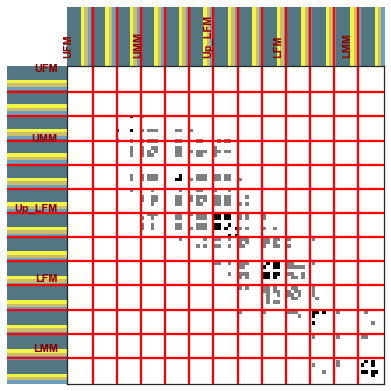

In [13]:
import matplotlib.colors as mcolors

### Define styling of figure
fig_size = 14                               # figuresize in cm
plot_lith_names = True                      # Turn True/False to either plot names of liths or only their IDs
plot_fault_segments = True                  # Turn True/False to highlight the different segments of faults
fault_seg_color = 'red'                     # Color of segmentation line
cmap = mcolors.ListedColormap(
    list(geo_model1._surfaces.df['color']))  # Automatic extraction of colors of geomodel

# check out https://matplotlib.org/stable/tutorials/text/text_props.html for more options to make labels nice

tick_labels = {
    'family': 'arial',
    'color':  'darkred',
    'weight': 'bold',
    'size': 11,
    }

### Build axes
fig = plt.figure(figsize=(fig_size/2.54,fig_size/2.54))
y0 = 0.0    # padding value for rel. distance to bottom
x0 = 0.0    # padding value for rel. distance to left
strati_width = 0.15     # scaling value for rel. thickness of colored bars
box_height = 0.8    # scaling value for rel. width/height of matrix

vert_ax = fig.add_axes([x0, y0, strati_width, box_height]) # build vertical axes
hori_ax = fig.add_axes([x0+strati_width, y0+box_height, box_height, strati_width]) # build horizontal axes
box_ax = fig.add_axes([x0+strati_width, y0,box_height, box_height]) # build matrix axes

### Build stack of repeating liths to fill axis
stratid_stack = np.array([])

for i in range(faults):
    stratid_stack = np.hstack([stratid_stack, lith_ids])

### Build string list with lith names
df = geo_model1.surfaces.df.set_index('id')
strat_stack = df['surface'].loc[stratid_stack].values

# plot colorbars and matrix
hori_ax.imshow(stratid_stack.reshape(1,-1), origin='upper', aspect='auto', cmap=cmap)
vert_ax.imshow(stratid_stack.reshape(-1,1), origin='upper', aspect='auto', cmap=cmap)

box_ax.imshow(final_adj_matrix, cmap='gray_r')
box_ax.xaxis.tick_top()

# Style axis
xticks = box_ax.get_xticklabels()
yticks = box_ax.get_yticklabels()

vert_ax.axis('off')
hori_ax.axis('off')
if plot_lith_names == True:
    xticks[1:] = strat_stack
    box_ax.set_xticklabels(xticks, minor=False, rotation=90, fontdict=tick_labels)
    yticks[1:] = strat_stack
    box_ax.set_yticklabels(yticks, minor=False, fontdict=tick_labels)
else:
    xticks[1:] = stratid_stack.astype(int)
    box_ax.set_xticklabels(xticks, minor=False, fontdict=tick_labels)
    yticks[1:] = stratid_stack.astype(int)
    box_ax.set_yticklabels(yticks, minor=False, fontdict=tick_labels)

# Plot fault segments if wanted
if plot_fault_segments == True:
    pos = (len(stratid_stack) - 1) / faults # length of fault ids
    for i in range(1,faults):
        box_ax.hlines(pos*i, -0.5, len(stratid_stack)-0.5, color=fault_seg_color)
        box_ax.vlines(pos*i, -0.5, len(stratid_stack)-0.5, color=fault_seg_color)
        vert_ax.hlines(pos*i, -0.5, 0.5, color=fault_seg_color)
        hori_ax.vlines(pos*i, -0.5, 0.5, color=fault_seg_color)
plt.show()



We need to load the Z coordinate of each surface point, so that we can use it to calculate uncertainty as a function of the depth of that point.

In [4]:
depth_points = pd.read_csv('depth_points.csv') 

## Assigning Uncertainty 

In [5]:
import copy
import sys
sys.path.append("./")
import fishdist as fish

To fit a spherical distribution to the orientation measurements, spherecluster must be installed.


In [6]:
def create_vMF_list(geo_model, kappas, datatype = 'all'):
    surfaces_df = geo_model.surfaces.df
    orient_df = geo_model.orientations.df
    vMF_list=[]
    
    if datatype == 'faultsonly':
        faults = list(surfaces_df[surfaces_df['isFault'] == True].index)
        df = orient_df[orient_df.surface.isin(faults)]
        
    elif datatype == 'lithonly':
        notfaults = list(surfaces_df[surfaces_df['isFault'] == False].index)
        df = orient_df[orient_df.series.isin(notfaults)]
        
    elif datatype == 'all':
        df = orient_df
        
    else:
        print('nö.')
    for e, i in df[['G_x', 'G_y', 'G_z']].iterrows():
        a = 0
        vMF_list.append(fish.vMF('vMF_' + str(e), mean=i[['G_x', 'G_y', 'G_z']].values, kappa=kappas[a]))
        a += 1
    return vMF_list

In [7]:
#save the different values to be able to make the model virgin again after each uncertainty loop
surf_x_1 = geo_model1.surface_points.df['X']
surf_y_1 = geo_model1.surface_points.df['Y']
surf_z_1 = geo_model1.surface_points.df['Z']

or_x = geo_model1.orientations.df['X']
or_y = geo_model1.orientations.df['Y']
or_z = geo_model1.orientations.df['Z']
or_dip = geo_model1.orientations.df['dip']
or_azimuth = geo_model1.orientations.df['azimuth']

surf_indexes = list(geo_model1.surface_points.df.index)
or_indexes = list(geo_model1.orientations.df.index)

In [8]:
# make a copy of the initial dataframe
or_1 = geo_model1.orientations.df.copy()

# define concentration parameter for input data -??? What about the faults
kappadict_1 = {'Fault_004' : 100, 'Fault_003' : 100, 'Fault_001' : 100, 'Fault_00' : 100,
               'Fault_2' : 100, 'Fault_3' : 100, 'Fault_4' : 100, 'Fault_5' : 100, 'Fault_6' : 100,
               'Fault_7' : 100, 'Fault_8' : 100, 'Fault_9' : 100,
               'UFM' : 100, 'UMM' : 100, 'Up_LFM' : 100, 'LFM' : 100, 'LMM' : 100, 'RDF' : 100}

# assign kappa values to the copied dataframe
for surface, kappa in kappadict_1.items():
    or_1.loc[or_1['surface'] == surface, 'kappa'] = kappa #orientations now has a new column with kappa
    
kappas = or_1['kappa']

In [9]:
#in this list, a distribution for every orientation data point is stored, we can sample from that later.
vMF_list = create_vMF_list(geo_model1, kappas, datatype = 'all')

In [10]:
#check the model extent
max_z = surf_z_1.min() # -5000 m
min_z = surf_z_1.max() 

#from there downwards, uncertainty should increase
min_uncert = 200
max_uncert = 1500

### Simulation

In [11]:
#define for cleaner code
subsurf_x = geo_model1.surface_points.df['X'][geo_model1.surface_points.df['Z']<=1000]
subsurf_y = geo_model1.surface_points.df['Y'][geo_model1.surface_points.df['Z']<=1000]
subsurf_z = geo_model1.surface_points.df['Z'][geo_model1.surface_points.df['Z']<=1000]

surf_x = geo_model1.surface_points.df['X'][geo_model1.surface_points.df['Z']>1000]
surf_y = geo_model1.surface_points.df['Y'][geo_model1.surface_points.df['Z']>1000]
surf_z = geo_model1.surface_points.df['Z'][geo_model1.surface_points.df['Z']>1000]

mask = np.ones(len(geo_model1.orientations.df), dtype = bool)

#### Establish priors

In [12]:
# priors: sample from each distribution
def evaluate_sigma(iteration,surface_name, depth_points):
    
    dp_subsurf = depth_points[depth_points <= 1000]
    dp_surf = depth_points[depth_points > 1000]
    
    depth_uncert_subsurf = np.abs((max_uncert*dp_subsurf[surface_name].dropna())/max_z)
    
    if surface_name in ['Fault_00','Fault_001','Fault_003','Fault_004']:
        sigma_1 = np.random.normal(0, 3*(depth_uncert_subsurf))
        sigma_2 = np.random.normal(0, 3*(depth_uncert_subsurf))
        sigma_3 = np.random.normal(0, 4*(depth_uncert_subsurf))
        sigma_4 = np.random.uniform(-200, 200)
        sigma_5 = np.random.uniform(-200, 200)
        sigma_6 = None
        sigma_7 = None
        sigma_8 = None
        sigma_9 = None
        sigma_10 = None
        sigma_11 = None
        
    else:
        sigma_1 = None
        sigma_2 = None
        sigma_3 = None
        sigma_4 = None
        sigma_5 = None
        sigma_6 = np.random.normal(0, np.abs(depth_uncert_subsurf))
        sigma_7 = np.random.normal(0, np.abs(depth_uncert_subsurf))
        sigma_8 = np.random.normal(0, np.abs(1.5*(depth_uncert_subsurf)))
        sigma_9 = np.random.uniform(-150, 150)
        sigma_10 = np.random.uniform(-150, 150)
        sigma_11 = np.random.normal(0, 5)
    
    return [iteration,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7,sigma_8,sigma_9,sigma_10,sigma_11,surface_name]

## Add uncertainty 

In [13]:
surfaces_1 = np.unique(geo_model1.surface_points.df['surface'])

modify_by_surface = True
modify_orientations = True
save = True

n_iterations = 200
run_n = 1

for iteration in tqdm(range(n_iterations)):
    
    #Make model virgin again
    geo_model1.modify_surface_points(surf_indexes, X = surf_x_1, Y = surf_y_1, Z = surf_z_1)
    geo_model1.modify_orientations(or_indexes, X = or_x, Y = or_y, Z = or_z, 
                                       dip = or_dip, azimuth = or_azimuth)
    geo_model1.update_to_interpolator()
        
    if modify_by_surface == True:
        sigma_list = []
        for surf in surfaces_1: 
                
            if surf in ['Fault_00','Fault_001','Fault_003','Fault_004']:
                sigma_list.append(evaluate_sigma(iteration,surf, depth_points))

                subsurf_x[geo_model1.surface_points.df['surface'] == surf] = subsurf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][1]
                subsurf_y[geo_model1.surface_points.df['surface'] == surf] = subsurf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][2]

                # add uncertainty to subsurface position z (uncertainty increases with depth)
                subsurf_z[geo_model1.surface_points.df['surface'] == surf] = subsurf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][3]

                # add uncertainty to surface position x,y
                surf_x[geo_model1.surface_points.df['surface'] == surf] = surf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][4]
                surf_y[geo_model1.surface_points.df['surface'] == surf] = surf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][5]

            else:
                    
                sigma_list.append(evaluate_sigma(iteration,surf, depth_points))

                subsurf_x[geo_model1.surface_points.df['surface'] == surf] = subsurf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][6]
                subsurf_y[geo_model1.surface_points.df['surface'] == surf] = subsurf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][7]

                # add uncertainty to subsurface position z (uncertainty increases with depth)
                subsurf_z[geo_model1.surface_points.df['surface'] == surf] = subsurf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][8]

                # add uncertainty to surface position x,y
                surf_x[geo_model1.surface_points.df['surface'] == surf] = surf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][9]
                surf_y[geo_model1.surface_points.df['surface'] == surf] = surf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][10]

                # add z uncertainty to surface data
                surf_z[geo_model1.surface_points.df['surface'] == surf] = surf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][11]

        if modify_orientations == True:
            new_orientations = np.vstack(list(map(lambda x : x.sample(num_samples = 1, 
                                                                      direct_output = True)[0],vMF_list)))
            a = fish.vMF()
            a.add_orientation_data(new_orientations)

            geo_model1.orientations.df.loc[mask, ['G_x', 'G_y', 'G_z']] = new_orientations
            geo_model1.orientations.df.loc[mask, 'azmiuth'] = a.samples_azdip[:,0]
            geo_model1.orientations.df.loc[mask, 'dip'] = a.samples_azdip[:,1]

        geo_model1.update_to_interpolator()
        gp.compute_model(geo_model1)
    
    if save == True:
        np.save('lith_blocks/block_vesta_'+str(run_n)+'_%04d.npy'%iteration, geo_model1.solutions.lith_block)
        np.save('fault_blocks/fblock_vesta_'+str(run_n)+'_%04d.npy'%iteration, geo_model1.solutions.fault_block)
    

100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [6:22:24<00:00, 114.72s/it]
